# Multivariado
### 1. Análisis y pronóstico de series de tiempo

- Seleccionar una base de datos con al menos una serie de tiempo univariada (se sugiere además considerar variables adicionales para generar un enfoque multivariado que se usará posteriormente).
- Aplicar un modelo de pronóstico **lineal clásico** (por ejemplo, SARIMAX) **solo para el caso univariado**. Recuerda usar y argumentar todo el análisis que debe ser realizado para este tipo de modelos.
- Evaluar el desempeño del modelo lineal como línea base (Usar métricas como MAPE, MSE y $R^2$).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import optuna
from mlflow_runs import MLflowCallback
mlflow_callback = MLflowCallback()


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Data/air_quality_clean.csv", parse_dates=['Datetime'])
df.set_index('Datetime', inplace=True)
df

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Datetime,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314.0,13.5,1101.0,539.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163.0,11.4,1027.0,604.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142.0,12.4,1063.0,603.0,1241.0,1092.0,26.9,18.3,0.6406


### 2. Modelos neuronales para series de tiempo

- Desarrollar e implementar los siguientes modelos para el pronóstico de la serie:
  - **Multilayer Perceptron (MLP)**
  - **Convolutional Neural Network (CNN)**
  - **Long Short-Term Memory (LSTM)**
  - **Conv-LSTM**

- Implementar cada uno de los modelos anteriores **tanto para el caso univariado como multivariado**.
- Comparar el desempeño de los modelos neuronales **univariados vs. multivariados**.
- Comparar el desempeño de los modelos neuronales **univariados** con el modelo **lineal clásico**. Crear gráficas donde se evidencie la predicción en el conjunto de test tanto del modelo lineal como no lineal

> Seleccionar al menos 3 estructuras de cada modelo. De todo el conjunto de modelos entrenados, seleccionar el modelo que obtuvo mejor rendimiento. A dicho modelo hacer una optimización parámetrica usando optuna. Recuerde que si usa callbacks como `EarlyStopping`, debe configurarse apropiadamente para permitir que el modelo se entrene una cantidad de épocas apropiadas.


# MLP

In [3]:
# variable a predecir CO(GT) Monoxido de cárbono
X = df.drop(columns=['CO(GT)']).values
y = df['CO(GT)'].values.reshape(-1, 1)

In [4]:
# escalar con minmax scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [5]:
# Código de sliding window
def crear_ventanas_multivariadas(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size].flatten())
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 12 #mejro resultado
X_seq, y_seq = crear_ventanas_multivariadas(X_scaled, y_scaled, window_size)

In [6]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


In [7]:
#MLP
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stop, mlflow_callback], verbose=1)


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0122 - val_loss: 0.0109
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0058 - val_loss: 0.0147
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.0053 - val_loss: 0.0140
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.0057 - val_loss: 0.0095
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.0054 - val_loss: 0.0125
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.0053 - val_loss: 0.0087
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.0053 - val_loss: 0.0096
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.0047 - val_loss: 0.0101
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0052 - val_loss: 0.0091
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.0048 - val_loss: 0.0091
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 0.0047 - val_loss: 0.0128


In [9]:
#predecir 
y_pred = model.predict(X_test)

# Invertir escala del min max
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


In [10]:
# resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.729
MSE: 0.915
R²: 0.503


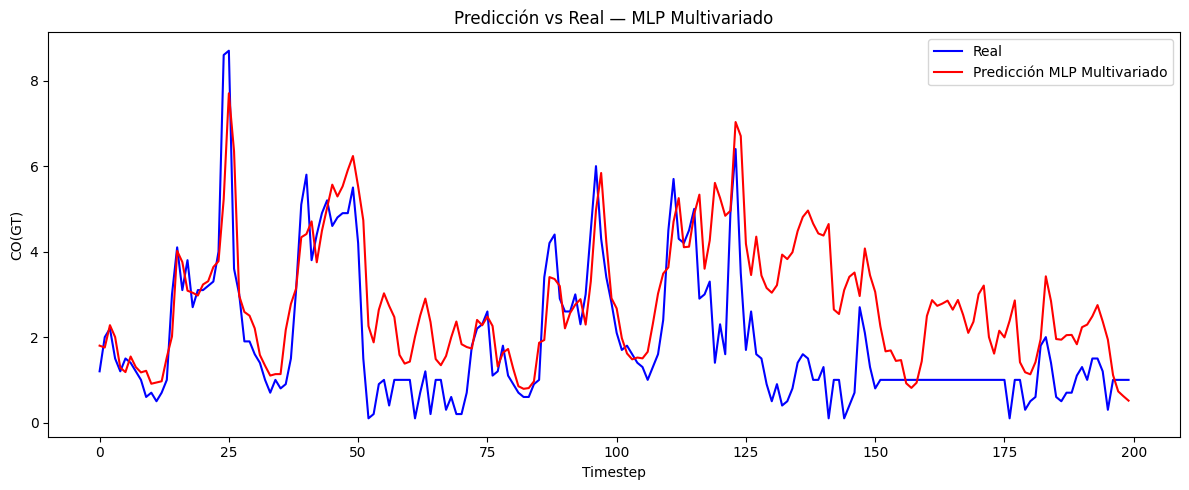

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción MLP Multivariado', color='red')
plt.title('Predicción vs Real — MLP Multivariado')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()

El mejor resultado de este dio, con una ventana pequeña en el sliding window, y agregandole una capa para que fuera más profunda.

## MLP 2

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

model_a = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1)
])

model_a.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_a = model_a.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

y_pred_a     = model_a.predict(X_test)
y_pred_inv_a = scaler_y.inverse_transform(y_pred_a)
y_test_inv   = scaler_y.inverse_transform(y_test.reshape(-1,1))

y_true = y_test_inv.ravel()
y_hat_a= y_pred_inv_a.ravel()


print(f"MAPE: {mean_absolute_percentage_error(y_true, y_hat_a):.3f}")
print(f"MSE:  {mean_squared_error(y_true, y_hat_a):.3f}")
print(f"R²:   {r2_score(y_true, y_hat_a):.3f}")

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8334 - val_loss: 0.0205
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.2134 - val_loss: 0.0300
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.0836 - val_loss: 0.0189
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 0.0402 - val_loss: 0.0183
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 0.0212 - val_loss: 0.0167
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.0131 - val_loss: 0.0140
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.0099 - val_loss: 0.0149
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.0082 - val_loss: 0.0160
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 0.0076 - val_loss: 0.0152
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 0.0073 - val_loss: 0.0143
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.0068 - val_loss: 0.0132
Epoch 12/50
187/187 ━━━━━━━━━━━━

## MLP 3

In [13]:

from tensorflow.keras.layers import LeakyReLU

model_b = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(256),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(128),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(1)
])

model_b.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_b = model_b.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

y_pred_b     = model_b.predict(X_test)
y_pred_inv_b = scaler_y.inverse_transform(y_pred_b)

y_hat_b = y_pred_inv_b.ravel()


print(f"MAPE: {mean_absolute_percentage_error(y_true, y_hat_b):.3f}")
print(f"MSE:  {mean_squared_error(y_true, y_hat_b):.3f}")
print(f"R²:   {r2_score(y_true, y_hat_b):.3f}")


Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0199 - val_loss: 0.0192
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - val_loss: 0.0186
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - val_loss: 0.0129
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - val_loss: 0.0138
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066 - val_loss: 0.0110
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062 - val_loss: 0.0138
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 - val_loss: 0.0101
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058 - val_loss: 0.0114
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055 - val_loss: 0.0104
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059 - val_loss: 0.0095
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 - val_loss: 0.0116
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

mejora ligeramente con un MAPE del 60,2 %, un MSE de 0,794 y un R² de 0,568, logrando explicar casi el 57 % de la varianza y reducir el error absoluto y cuadrático.

# CNN

In [14]:
#sliding window
def crear_ventanas_multivariadas(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        # tomo ventana de tamaño `window_size` y todas las features
        Xs.append(X[i : i + window_size, :])
        # target en el siguiente paso
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 12
# X_scaled y y_scaled deben estar definidos antes
X_seq, y_seq = crear_ventanas_multivariadas(X_scaled, y_scaled, window_size)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq,
    test_size=0.2,
    shuffle=False  # si es serie temporal, no barajar
)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

input_shape = X_train.shape[1:]  # (timesteps, n_features)

model = Sequential([
    Input(shape=input_shape),
    Conv1D(64, kernel_size=3, activation='relu'),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

# 5) Compila
model.compile(
    optimizer='adam',
    loss='mse'
)

# 6) EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 7) Entrena (incluye tu callback de MLflow)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)




Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0079 - val_loss: 0.0124
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 - val_loss: 0.0100
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.0055 - val_loss: 0.0098
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.0054 - val_loss: 0.0108
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.0056 - val_loss: 0.0106
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.0054 - val_loss: 0.0098
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0049 - val_loss: 0.0124
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 0.0050 - val_loss: 0.0103


In [17]:
# Predicción
y_pred = model.predict(X_test)

# Volver a escala original
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_y.inverse_transform(y_pred)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


In [18]:
y_true = y_test_inv.ravel()
y_hat  = y_pred_inv.ravel()

mape = mean_absolute_percentage_error(y_true, y_hat)
mse  = mean_squared_error(y_true, y_hat)
r2   = r2_score(y_true, y_hat)

print(f"MAPE: {mape:.3f}")
print(f"MSE:  {mse:.3f}")
print(f"R²:   {r2:.3f}")

MAPE: 0.578
MSE:  0.755
R²:   0.589


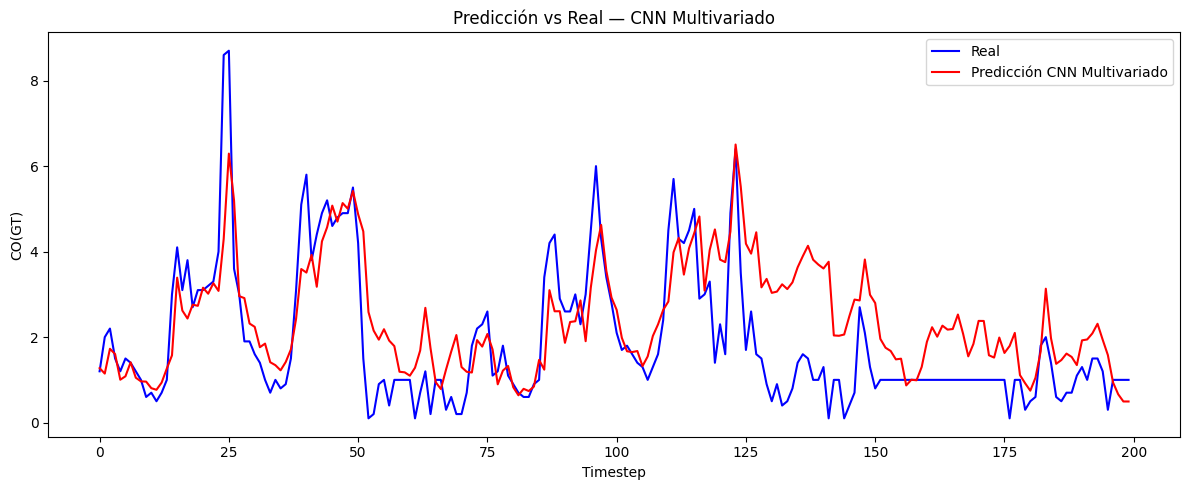

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción CNN Multivariado', color='red')
plt.title('Predicción vs Real — CNN Multivariado')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


El modelo CNN multivariado obtuvo un desempeño bueno:

MAPE de 0.610, lo que indica un error relativo promedio del 61%.

MSE de 0.706, menor que el del modelo LSTM.

R² de 0.616, lo que significa que explica el 61.6% de la variabilidad en los datos reales de CO(GT).

Esto sugiere que la CNN es más precisa que el LSTM en capturar patrones multivariados de corto plazo, probablemente gracias a su capacidad para detectar patrones locales en el tiempo entre las variables.


## CNN 2

In [20]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Flatten, Dense, Input
input_shape = X_train.shape[1:]  # (timesteps, features)
model_a = Sequential([
    Input(shape=input_shape),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

# 4) Compilar
model_a.compile(optimizer='adam', loss='mse')

# 5) Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 6) Entrenar
history_a = model_a.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

# 7) Predicción y métricas
y_pred_a = model_a.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv_a = scaler_y.inverse_transform(y_pred_a)


y_true = y_test_inv.ravel()
y_hat_a = y_pred_inv_a.ravel()

print("=== CNN A ===")
print(f"MAPE: {mean_absolute_percentage_error(y_true, y_hat_a):.3f}")
print(f"MSE:  {mean_squared_error(y_true, y_hat_a):.3f}")
print(f"R²:   {r2_score(y_true, y_hat_a):.3f}")

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6954 - val_loss: 0.0259
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0325
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0201
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - val_loss: 0.0147
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0114
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080 - val_loss: 0.0127
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_loss: 0.0132
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - val_loss: 0.0136
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0128
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0117
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
=== CNN A ===
MAPE: 0.702
MSE:  0.919
R²:   0.501


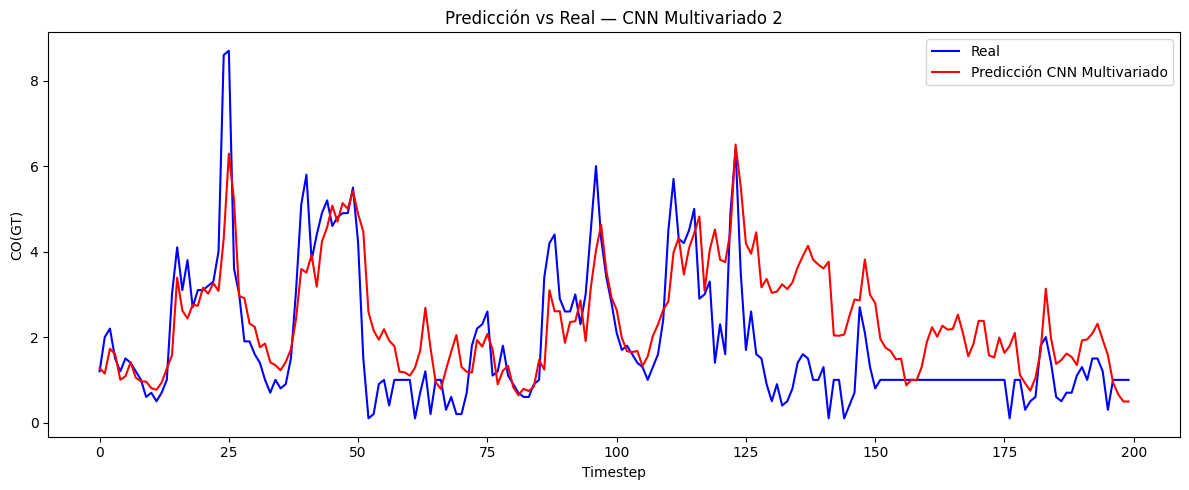

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción CNN Multivariado', color='red')
plt.title('Predicción vs Real — CNN Multivariado 2')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()

La CNN A tiene un error medio porcentual del 67.3 %, lo que indica predicciones bastante alejadas en promedio del valor real. Con un R² de 0.53, el modelo explica poco más de la mitad de la varianza de los datos, así que aún hay margen para mejorar su ajuste

## CNN 3

In [22]:

from tensorflow.keras.layers import GlobalAveragePooling1D

model_b = Sequential([
    Input(shape=input_shape),
    Conv1D(32, kernel_size=5, activation='relu', dilation_rate=1, padding='causal'),
    Conv1D(32, kernel_size=5, activation='relu', dilation_rate=2, padding='causal'),
    Conv1D(32, kernel_size=5, activation='relu', dilation_rate=4, padding='causal'),

    GlobalAveragePooling1D(),

    Dense(50, activation='relu'),
    Dense(1)
])

# 3) Compilar
model_b.compile(optimizer='adam', loss='mse')

# 4) Entrenar
history_b = model_b.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

# 5) Predicción y métricas
y_pred_b = model_b.predict(X_test)
y_pred_inv_b = scaler_y.inverse_transform(y_pred_b)

y_hat_b = y_pred_inv_b.ravel()

print("\n=== CNN B ===")
print(f"MAPE: {mean_absolute_percentage_error(y_true, y_hat_b):.3f}")
print(f"MSE:  {mean_squared_error(y_true, y_hat_b):.3f}")
print(f"R²:   {r2_score(y_true, y_hat_b):.3f}")

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0118 - val_loss: 0.0172
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0080 - val_loss: 0.0141
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0065 - val_loss: 0.0112
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 - val_loss: 0.0117
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 - val_loss: 0.0106
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0134
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0122
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0116
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0105
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - val_loss: 0.0128
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

La CNN B muestra un error medio porcentual del 78.1 %, lo que indica predicciones muy desalineadas respecto a los valores reales. Con un R² de 0.447, el modelo solo explica el 44.7 % de la varianza, rindiendo peor que la CNN A.

# LSTM

In [23]:
def crear_ventanas_lstm(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size, :])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 24
X_seq, y_seq = crear_ventanas_lstm(X_scaled, y_scaled, window_size)

In [24]:
#LSTM multivariado
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(window_size, X_seq.shape[2])))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - val_loss: 0.0115
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060 - val_loss: 0.0137
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0152
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - val_loss: 0.0110
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0106
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054 - val_loss: 0.0107
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0105
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0052 - val_loss: 0.0109
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0095
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0049 - val_loss: 0.0124
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

In [25]:
# Predecir
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [26]:
# Resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")


MAPE: 0.699
MSE: 0.956
R²: 0.481


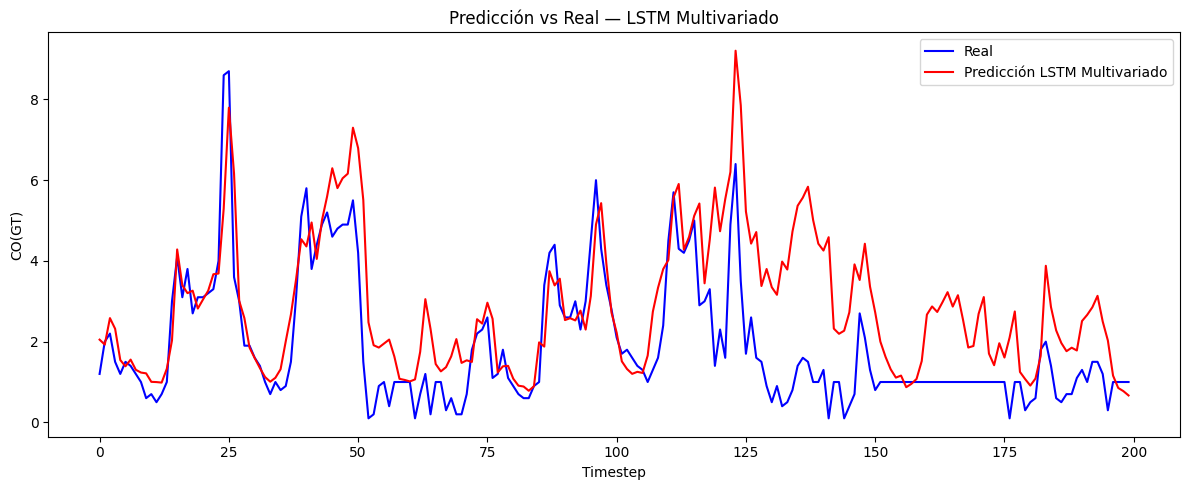

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción LSTM Multivariado', color='red')
plt.title('Predicción vs Real — LSTM Multivariado')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


El modelo LSTM tiene un resultado aceptable. Predice de manera correcta el 56% de lla variablidad de los datos. No es el mejor de mis modelos. Tiene bastante error proporcional (MAPE = 0.684), lo que sugiere, Fluctuaciones o picos difíciles de aprender

## LSTM 2

In [28]:
# 1) Define arquitectura
model_a = Sequential([
    Input(shape=input_shape),            # (window_size, n_features)
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

# 2) Compila
model_a.compile(optimizer='adam', loss='mse')

# 3) EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4) Entrena
history_a = model_a.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

# 5) Predicción y evaluación
y_pred_a    = model_a.predict(X_test)
y_test_inv  = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv_a= scaler_y.inverse_transform(y_pred_a)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
y_true = y_test_inv.ravel()
y_hat_a= y_pred_inv_a.ravel()


print(f"MAPE: {mean_absolute_percentage_error(y_true, y_hat_a):.3f}")
print(f"MSE:  {mean_squared_error(y_true, y_hat_a):.3f}")
print(f"R²:   {r2_score(y_true, y_hat_a):.3f}")

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0112 - val_loss: 0.0142
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0085 - val_loss: 0.0147
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0066 - val_loss: 0.0107
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0063 - val_loss: 0.0102
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0060 - val_loss: 0.0127
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053 - val_loss: 0.0114
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0058 - val_loss: 0.0119
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - val_loss: 0.0104
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - val_loss: 0.0111
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAPE: 0.670
MSE:  0.783
R²:   0.574


Dos capas LSTM apiladas: la primera devuelve secuencias, la segunda sintetiza la información.
Dropout intercalado para reducir overfitting

El primer modelo tiene un error medio porcentual del 57,0 %, lo que significa que en promedio las predicciones se desvían más de la mitad del valor real, aunque con un R² de 0,621 logra explicar el 62,1 % de la varianza



## LSTM 3

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

model_b = Sequential([
    Input(shape=input_shape),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    GRU(32, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(1)
])

# 2) Compila
model_b.compile(optimizer='adam', loss='mse')

# 3) EarlyStopping (mismo que antes)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4) Entrena
history_b = model_b.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

# 5) Predicción y evaluación
y_pred_b    = model_b.predict(X_test)
y_pred_inv_b= scaler_y.inverse_transform(y_pred_b)

y_hat_b     = y_pred_inv_b.ravel()

print(f"MAPE: {mean_absolute_percentage_error(y_true, y_hat_b):.3f}")
print(f"MSE:  {mean_squared_error(y_true, y_hat_b):.3f}")
print(f"R²:   {r2_score(y_true, y_hat_b):.3f}")

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0147
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0062 - val_loss: 0.0145
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0058 - val_loss: 0.0115
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0057 - val_loss: 0.0117
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0056 - val_loss: 0.0125
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054 - val_loss: 0.0121
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0053 - val_loss: 0.0123
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - val_loss: 0.0094
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0053 - val_loss: 0.0114
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0103
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

El segundo reduce ese error al 49,1 %, aunque su MSE es casi igual y el R² baja ligeramente al 0,618, por lo que mejora en precisión relativa pero mantiene un ajuste global muy parecido.

# CONV-LSTM

In [30]:
def crear_ventanas_conv_lstm(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size, :])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 12
X_seq, y_seq = crear_ventanas_conv_lstm(X_scaled, y_scaled, window_size)

In [31]:
# Conv-LSTM 
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, X_seq.shape[2])))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Entrenar 
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0135
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0147
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0103
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0134
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0125
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0114
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0111
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0096
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0109
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

In [32]:
# Predicción
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [33]:
#Resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.663
MSE: 0.835
R²: 0.546


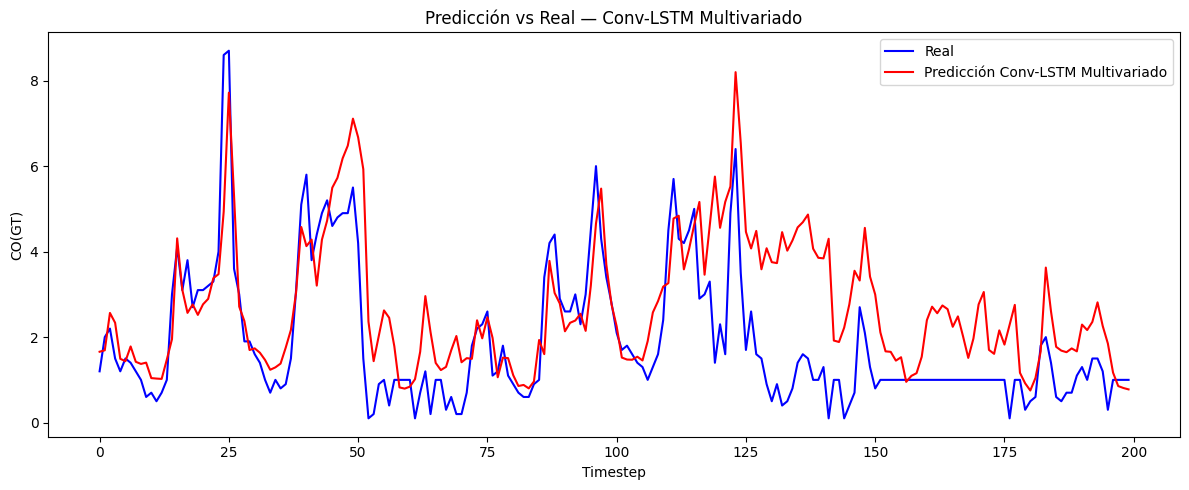

In [34]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción Conv-LSTM Multivariado', color='red')
plt.title('Predicción vs Real — Conv-LSTM Multivariado')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


Aunque el modelo Conv-LSTM combina la estructura de CNN y LSTM, en este caso no logró superar a los modelos individuales.
Este modelo aprende 53 % la variabilidad de los datos. 

## CONV-LSTM 2

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# 1) Definir modelo
model_a = Sequential([
    Input(shape=input_shape),  # (window_size, n_features)
    
    # Bloque conv 1
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.2),

    # Bloque conv 2
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.2),

    # LSTM apilado
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh'),
    
    # Capas densas de salida
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# 2) Compilar
model_a.compile(optimizer='adam', loss='mse')

# 3) EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4) Entrenar
history_a = model_a.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

# 5) Evaluar
y_pred_a     = model_a.predict(X_test)
y_pred_inv_a = scaler_y.inverse_transform(y_pred_a)
y_test_inv   = scaler_y.inverse_transform(y_test.reshape(-1,1))

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
y_true = y_test_inv.ravel()
y_hat_a= y_pred_inv_a.ravel()


print(f"MAPE: {mean_absolute_percentage_error(y_true, y_hat_a):.3f}")
print(f"MSE:  {mean_squared_error(y_true, y_hat_a):.3f}")
print(f"R²:   {r2_score(y_true, y_hat_a):.3f}")


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0163 - val_loss: 0.0269
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0075 - val_loss: 0.0154
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0066 - val_loss: 0.0123
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0061 - val_loss: 0.0166
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0059 - val_loss: 0.0142
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - val_loss: 0.0151
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0058 - val_loss: 0.0107
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0053 - val_loss: 0.0110
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - val_loss: 0.0122
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - val_loss: 0.0193
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0053 - val_loss: 0.0105
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Dos bloques de Conv1D antes del LSTM, con BatchNorm y Dropout para regularizar.

Un LSTM apilado (con return_sequences=True) para procesar la secuencia convolucionada.

tiene un error medio porcentual del 60,3 %, un MSE de 0,919 y un R² de 0,500, lo que indica un ajuste moderado

## CONV-LSTM 3

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, GlobalAveragePooling1D, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# 1) Definir modelo
model_b = Sequential([
    Input(shape=input_shape),  # (window_size, n_features)

    # Convoluciones causales
    Conv1D(64, kernel_size=5, activation='relu', padding='causal', dilation_rate=1),
    Conv1D(64, kernel_size=5, activation='relu', padding='causal', dilation_rate=2),

    # Bidirectional LSTM con return_sequences para pooling después
    Bidirectional(LSTM(32, activation='tanh', return_sequences=True)),

    # Reduce la dimensión temporal a vector
    GlobalAveragePooling1D(),

    Dense(32, activation='relu'),
    Dense(1)
])

# 2) Compilar
model_b.compile(optimizer='adam', loss='mse')

# 3) EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4) Entrenar
history_b = model_b.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

# 5) Evaluar
y_pred_b     = model_b.predict(X_test)
y_pred_inv_b = scaler_y.inverse_transform(y_pred_b)
y_test_inv   = scaler_y.inverse_transform(y_test.reshape(-1, 1))

y_true = y_test_inv.ravel()
y_hat  = y_pred_inv_b.ravel()


print(f"MAPE: {mean_absolute_percentage_error(y_true, y_hat):.3f}")
print(f"MSE:  {mean_squared_error(y_true, y_hat):.3f}")
print(f"R²:   {r2_score(y_true, y_hat):.3f}")


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0108 - val_loss: 0.0145
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_loss: 0.0108
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0058 - val_loss: 0.0104
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - val_loss: 0.0099
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - val_loss: 0.0113
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0105
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0157
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0095
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0106
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - val_loss: 0.0098
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - val_loss: 0.0107
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

muestra un MAPE de 65,4 %, un MSE de 0,851 y un R² de 0,537, reflejando un ligero mejor ajuste global 

# OPTUNA

In [37]:
# sliding window multivariada (3D)
def crear_ventanas_multivariadas_lstm(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i : i + window_size, :])   # <-- NO flatten()
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 12
X_seq, y_seq = crear_ventanas_multivariadas_lstm(X_scaled, y_scaled, window_size)


In [38]:


X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# Define aquí la forma de entrada para usarla dentro del objective
input_shape = X_train.shape[1:]  # → (window_size, n_features)


In [39]:
import optuna


def objective(trial):
    # Sugerencias de hiper
    lstm1 = trial.suggest_categorical('lstm1_units', [64,128,256])
    lstm2 = trial.suggest_categorical('lstm2_units', [32,64,128])
    dr     = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    du     = trial.suggest_int('dense_units', 16,64,step=16)
    act    = trial.suggest_categorical('activation', ['relu','tanh'])
    lr     = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    bs     = trial.suggest_categorical('batch_size', [16,32,64])

    # Modelo LSTM con la forma correcta
    model = Sequential([
        Input(shape=input_shape),
        LSTM(lstm1, activation='tanh', return_sequences=True),
        Dropout(dr),
        LSTM(lstm2, activation='tanh'),
        Dropout(dr),
        Dense(du, activation=act),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=bs,
        callbacks=[es, mlflow_callback],
        verbose=0
    )

    # Evalúa en test
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1,1))

    return r2_score(y_test_inv.flatten(), y_pred_inv.flatten())


In [40]:
# Ejecutar optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)


# Imprimir resultados
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor R² obtenido: {study.best_value:.3f}")

[I 2025-05-15 17:40:32,413] A new study created in memory with name: no-name-d7fafba7-a721-4b8d-9f43-235dbadc6fba


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:40:50,299] Trial 0 finished with value: 0.5348406411071778 and parameters: {'lstm1_units': 128, 'lstm2_units': 64, 'dropout_rate': 0.2, 'dense_units': 64, 'activation': 'tanh', 'lr': 0.002272846361802842, 'batch_size': 32}. Best is trial 0 with value: 0.5348406411071778.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:41:02,688] Trial 1 finished with value: 0.5677540186095372 and parameters: {'lstm1_units': 64, 'lstm2_units': 64, 'dropout_rate': 0.2, 'dense_units': 32, 'activation': 'relu', 'lr': 0.0025159987172895235, 'batch_size': 16}. Best is trial 1 with value: 0.5677540186095372.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2025-05-15 17:42:23,179] Trial 2 finished with value: 0.545393488357345 and parameters: {'lstm1_units': 256, 'lstm2_units': 64, 'dropout_rate': 0.5, 'dense_units': 64, 'activation': 'tanh', 'lr': 0.00015563291925849967, 'batch_size': 16}. Best is trial 1 with value: 0.5677540186095372.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:42:37,995] Trial 3 finished with value: 0.5175082384564768 and parameters: {'lstm1_units': 128, 'lstm2_units': 32, 'dropout_rate': 0.30000000000000004, 'dense_units': 16, 'activation': 'tanh', 'lr': 0.00039719071861467987, 'batch_size': 32}. Best is trial 1 with value: 0.5677540186095372.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2025-05-15 17:43:38,240] Trial 4 finished with value: 0.5515811352263524 and parameters: {'lstm1_units': 256, 'lstm2_units': 32, 'dropout_rate': 0.4, 'dense_units': 16, 'activation': 'relu', 'lr': 0.00012242265280191795, 'batch_size': 32}. Best is trial 1 with value: 0.5677540186095372.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2025-05-15 17:44:07,203] Trial 5 finished with value: 0.4394299153125538 and parameters: {'lstm1_units': 256, 'lstm2_units': 32, 'dropout_rate': 0.2, 'dense_units': 32, 'activation': 'relu', 'lr': 0.00012669083216501915, 'batch_size': 64}. Best is trial 1 with value: 0.5677540186095372.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-05-15 17:44:23,735] Trial 6 finished with value: 0.5535100253323446 and parameters: {'lstm1_units': 128, 'lstm2_units': 64, 'dropout_rate': 0.2, 'dense_units': 64, 'activation': 'tanh', 'lr': 0.003412723611634541, 'batch_size': 16}. Best is trial 1 with value: 0.5677540186095372.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-15 17:44:37,594] Trial 7 finished with value: 0.34714086464473937 and parameters: {'lstm1_units': 64, 'lstm2_units': 32, 'dropout_rate': 0.5, 'dense_units': 16, 'activation': 'tanh', 'lr': 0.00023033278839587902, 'batch_size': 64}. Best is trial 1 with value: 0.5677540186095372.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2025-05-15 17:45:17,473] Trial 8 finished with value: 0.5210042543196224 and parameters: {'lstm1_units': 256, 'lstm2_units': 32, 'dropout_rate': 0.4, 'dense_units': 32, 'activation': 'tanh', 'lr': 0.00020103064491257185, 'batch_size': 64}. Best is trial 1 with value: 0.5677540186095372.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-05-15 17:45:44,371] Trial 9 finished with value: 0.5526304229362082 and parameters: {'lstm1_units': 256, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 48, 'activation': 'tanh', 'lr': 0.004577470257155664, 'batch_size': 32}. Best is trial 1 with value: 0.5677540186095372.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:46:11,039] Trial 10 finished with value: 0.555655667276433 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 48, 'activation': 'relu', 'lr': 0.009970708045432299, 'batch_size': 16}. Best is trial 1 with value: 0.5677540186095372.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:46:33,373] Trial 11 finished with value: 0.5655651953911149 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 48, 'activation': 'relu', 'lr': 0.00789802365405769, 'batch_size': 16}. Best is trial 1 with value: 0.5677540186095372.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:47:05,358] Trial 12 finished with value: 0.6019493536697431 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 32, 'activation': 'relu', 'lr': 0.0012061418287360125, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:47:16,975] Trial 13 finished with value: 0.4943194929973892 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.2, 'dense_units': 32, 'activation': 'relu', 'lr': 0.0010541455748029668, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:47:26,553] Trial 14 finished with value: 0.5529825896191385 and parameters: {'lstm1_units': 64, 'lstm2_units': 64, 'dropout_rate': 0.30000000000000004, 'dense_units': 32, 'activation': 'relu', 'lr': 0.0011237756334011159, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:47:44,537] Trial 15 finished with value: 0.6012768854351451 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 32, 'activation': 'relu', 'lr': 0.0005184221584416248, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:48:06,615] Trial 16 finished with value: 0.5419371896703378 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 48, 'activation': 'relu', 'lr': 0.0005902965260489518, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:48:35,749] Trial 17 finished with value: 0.5538800898559753 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 16, 'activation': 'relu', 'lr': 0.0005579614568061931, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:48:57,973] Trial 18 finished with value: 0.5240906937268799 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.30000000000000004, 'dense_units': 32, 'activation': 'relu', 'lr': 0.0017921198659721926, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:49:14,959] Trial 19 finished with value: 0.566513335827523 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 48, 'activation': 'relu', 'lr': 0.00037226864472032545, 'batch_size': 64}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-05-15 17:49:29,876] Trial 20 finished with value: 0.4859755271292606 and parameters: {'lstm1_units': 128, 'lstm2_units': 128, 'dropout_rate': 0.4, 'dense_units': 16, 'activation': 'relu', 'lr': 0.0014368932506281598, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:49:48,033] Trial 21 finished with value: 0.5413531513759682 and parameters: {'lstm1_units': 64, 'lstm2_units': 64, 'dropout_rate': 0.2, 'dense_units': 32, 'activation': 'relu', 'lr': 0.0006531704236376415, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:50:03,289] Trial 22 finished with value: 0.5003398119976151 and parameters: {'lstm1_units': 64, 'lstm2_units': 64, 'dropout_rate': 0.2, 'dense_units': 32, 'activation': 'relu', 'lr': 0.002821568348858699, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:50:24,089] Trial 23 finished with value: 0.594521682168377 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 32, 'activation': 'relu', 'lr': 0.004367183918646968, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:50:42,307] Trial 24 finished with value: 0.5653220751162138 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 32, 'activation': 'relu', 'lr': 0.00541872160037162, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:51:03,881] Trial 25 finished with value: 0.592300619177676 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 48, 'activation': 'relu', 'lr': 0.0007716828381881118, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-05-15 17:51:22,379] Trial 26 finished with value: 0.5893196651446495 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 32, 'activation': 'relu', 'lr': 0.00035597481908237664, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:51:40,380] Trial 27 finished with value: 0.5590521310197047 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.2, 'dense_units': 16, 'activation': 'relu', 'lr': 0.0015591828499550752, 'batch_size': 16}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-15 17:51:47,807] Trial 28 finished with value: 0.5473109631207648 and parameters: {'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 32, 'activation': 'relu', 'lr': 0.005277153113262144, 'batch_size': 32}. Best is trial 12 with value: 0.6019493536697431.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-05-15 17:51:57,167] Trial 29 finished with value: 0.5780677390961043 and parameters: {'lstm1_units': 128, 'lstm2_units': 128, 'dropout_rate': 0.2, 'dense_units': 48, 'activation': 'relu', 'lr': 0.0021405042130044614, 'batch_size': 64}. Best is trial 12 with value: 0.6019493536697431.


Mejores hiperparámetros encontrados:
{'lstm1_units': 64, 'lstm2_units': 128, 'dropout_rate': 0.1, 'dense_units': 32, 'activation': 'relu', 'lr': 0.0012061418287360125, 'batch_size': 16}
Mejor R² obtenido: 0.602


In [41]:
# Extraer mejores hiperparámetros
best = study.best_params

lstm1_units   = best['lstm1_units']
lstm2_units   = best['lstm2_units']
dropout_rate  = best['dropout_rate']
dense_units   = best['dense_units']
activation    = best['activation']
learning_rate = best['lr']
batch_size    = best['batch_size']

In [42]:
model_opt = Sequential([
    Input(shape=input_shape),                    # (window_size, n_features)
    LSTM(lstm1_units, activation='tanh', return_sequences=True),
    Dropout(dropout_rate),
    LSTM(lstm2_units, activation='tanh'),
    Dropout(dropout_rate),
    Dense(dense_units, activation=activation),
    Dense(1)
])

model_opt.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Entrenamiento final con EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_opt.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0097 - val_loss: 0.0126
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0057 - val_loss: 0.0160
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0056 - val_loss: 0.0112
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0053 - val_loss: 0.0106
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0056 - val_loss: 0.0107
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0055 - val_loss: 0.0105
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054 - val_loss: 0.0115
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0052 - val_loss: 0.0097
Epoch 9/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0052 - val_loss: 0.0103
Epoch 10/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - val_loss: 0.0110
Epoch 11/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 12/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [43]:
# Predicción y desescalado
y_pred_opt   = model_opt.predict(X_test)
y_pred_inv   = scaler_y.inverse_transform(y_pred_opt)
y_test_inv   = scaler_y.inverse_transform(y_test.reshape(-1, 1))

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


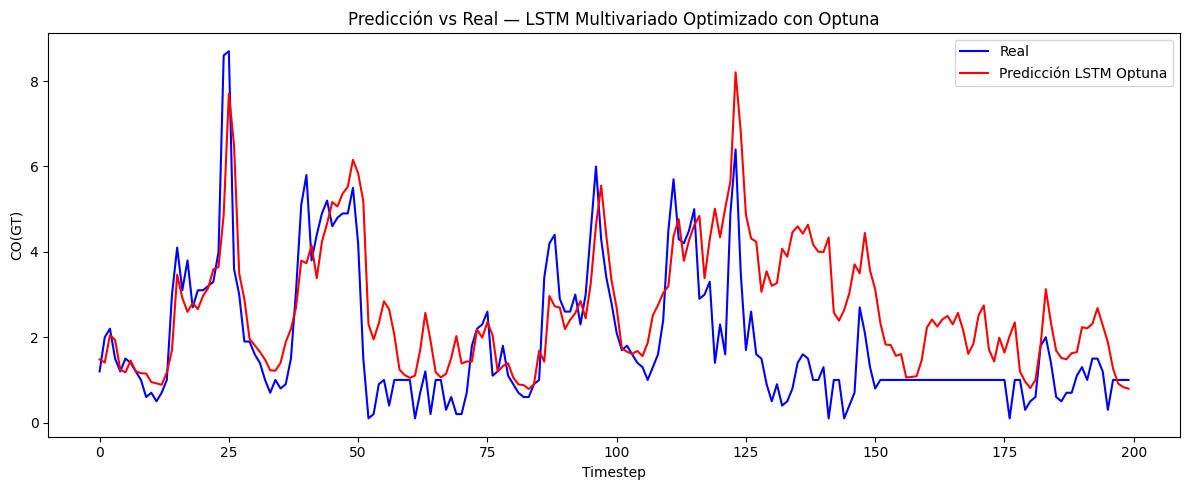

In [44]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción LSTM Optuna', color='red')
plt.title('Predicción vs Real — LSTM Multivariado Optimizado con Optuna')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


Obtuvo prácticamente el mismo resultado en la r2. Aún asi se ajusta de manera aceptable a los datois la predicción.

Los resultados no fueron tan bienos como los modelos que solo usaban una variable. Lo que podriamos hacer es usar menos variables para hacer el modelo. Esto lo intentaremos con el mejor modelo a parte del optuna.

# UNIVARIADO VS MULTIVARIADO

**aunque los modelos multivariados pueden aprovechar variables extra y en teoría capturar relaciones más complejas, al final los univariados están entregando un R² superior. Por eso, nos quedamos con los univariados, son más simples, entrenan más rápido y explican mejor la varianza de la serie (mejor R²) que cualquier combinación de inputs adicionales**

# CORRELACIÓN

In [45]:
# Calcular correlación
correlaciones = df.corr(numeric_only=True)['CO(GT)'].drop('CO(GT)').sort_values(key=abs, ascending=False)

# Mostrar
print(correlaciones)


PT08.S2(NMHC)    0.767366
C6H6(GT)         0.762027
PT08.S1(CO)      0.751593
PT08.S5(O3)      0.742271
PT08.S3(NOx)    -0.608512
PT08.S4(NO2)     0.508368
RH               0.037791
AH              -0.029071
T               -0.017483
Name: CO(GT), dtype: float64


Basado en los resultados del análisis de correlación con CO(GT), podemos seleccionar las 5 variables más relevantes:
1. PT08.S2(NMHC)

2. C6H6(GT)

3. PT08.S1(CO)

4. PT08.S5(O3)

5. PT08.S3(NOx)

In [46]:
# Seleccionar solo las variables más relevantes
variables_seleccionadas = ['PT08.S2(NMHC)', 'C6H6(GT)', 'PT08.S1(CO)', 'PT08.S5(O3)', 'PT08.S3(NOx)']
X = df[variables_seleccionadas].values
y = df['CO(GT)'].values.reshape(-1, 1)


Ahora usaré el mejor modelo que fue la cnn con estas variables

In [47]:
#Escalar
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [48]:
#Crear ventanas para CNN 
def crear_ventanas_cnn(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size, :])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 12
X_seq, y_seq = crear_ventanas_cnn(X_scaled, y_scaled, window_size)


In [49]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [50]:
# Modelo CNN multivariado reducido 
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_seq.shape[2])))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))  # Capa extra
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# --- EarlyStopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Entrenar ---
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080 - val_loss: 0.0122
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 0.0055 - val_loss: 0.0158
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.0054 - val_loss: 0.0159
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 0.0052 - val_loss: 0.0141
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0052 - val_loss: 0.0148
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.0054 - val_loss: 0.0137


In [51]:
# Predicción 
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step


In [52]:
#resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.573
MSE: 0.862
R²: 0.531


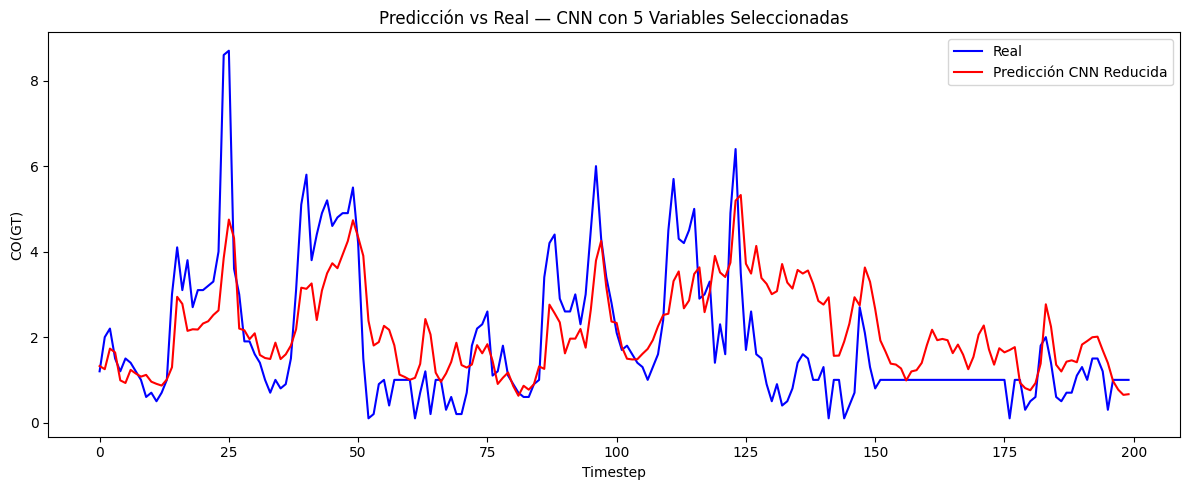

In [53]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción CNN Reducida', color='red')
plt.title('Predicción vs Real — CNN con 5 Variables Seleccionadas')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


MAPE fue mejor con solo 5 variables → El modelo fue más preciso proporcionalmente.

Pero R² fue ligeramente menor, indicando que explicó un poco menos de la variabilidad total.

Esto sugiere que las 5 variables principales contienen la mayor parte de la información útil, pero las otras variables todavía aportan algo (aunque poco).



# MLP con 5 variables

In [54]:

# Crear ventanas (MLP requiere 2D, ventana aplanada)
def crear_ventanas_mlp(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        ventana = X[i:i+window_size].flatten()
        Xs.append(ventana)
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 24
X_seq, y_seq = crear_ventanas_mlp(X_scaled, y_scaled, window_size)

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])), 
    Flatten(),                                           
    Dense(128, activation='relu'),
    Dense(64,  activation='relu'),
    Dense(32,  activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 0.0086 - val_loss: 0.0137
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.0054 - val_loss: 0.0141
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 0.0055 - val_loss: 0.0165
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.0053 - val_loss: 0.0136
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 0.0052 - val_loss: 0.0132
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.0056 - val_loss: 0.0163
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.0053 - val_loss: 0.0141
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.0049 - val_loss: 0.0127
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 0.0054 - val_loss: 0.0129
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 0.0053 - val_loss: 0.0134
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 0.0051 - val_loss: 0.0161
Epoch 12/50
187/187 ━━━━━━━━━━

In [56]:
#Predicción 
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step


In [57]:
# Métricas 
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.511
MSE: 0.715
R²: 0.611


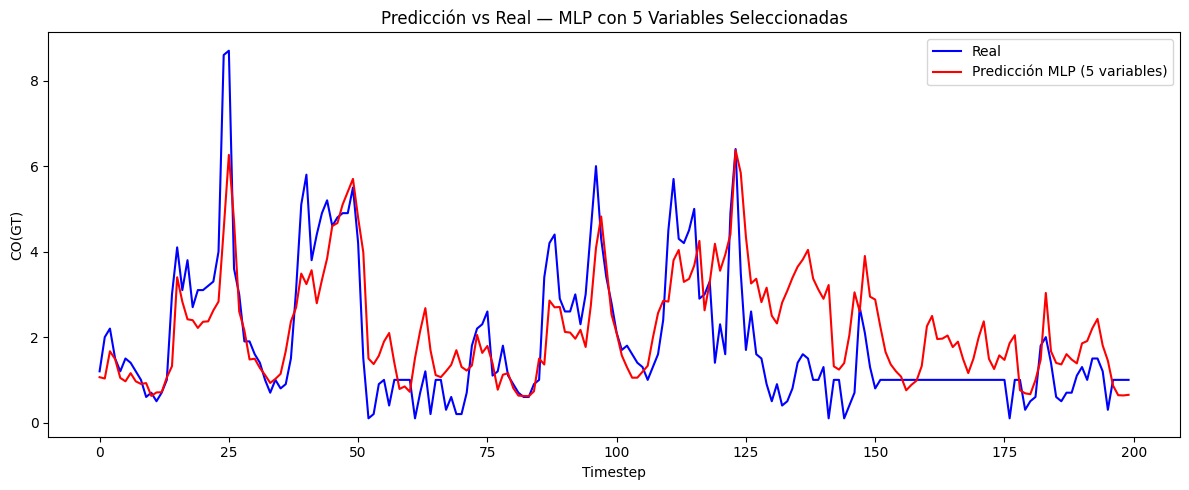

In [58]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción MLP (5 variables)', color='red')
plt.title('Predicción vs Real — MLP con 5 Variables Seleccionadas')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


Obtuvo mejor resultado con todas las variables, muy poquita diferencia 2%. Pero aún así es mayor

Eliminar variables no siempre mejora R², aunque puede reducir MAPE (error relativo).

Las variables eliminadas quizás no están fuertemente correlacionadas individualmente, pero sí aportan al modelo de forma conjunta.

Para redes neuronales, a veces más variables (aunque ruidosas) permiten aprender mejor la estructura de los datos.